In [2]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import gaussian_filter

<ipython-input-3-3b277d79210a>:69: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = fig.colorbar(cf, cax=cbar_ax, orientation='vertical', ticks=clevs, extend='')
<ipython-input-3-3b277d79210a>:109: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = fig.colorbar(cf, cax=cbar_ax, orientation='vertical', ticks=clevs, extend='')


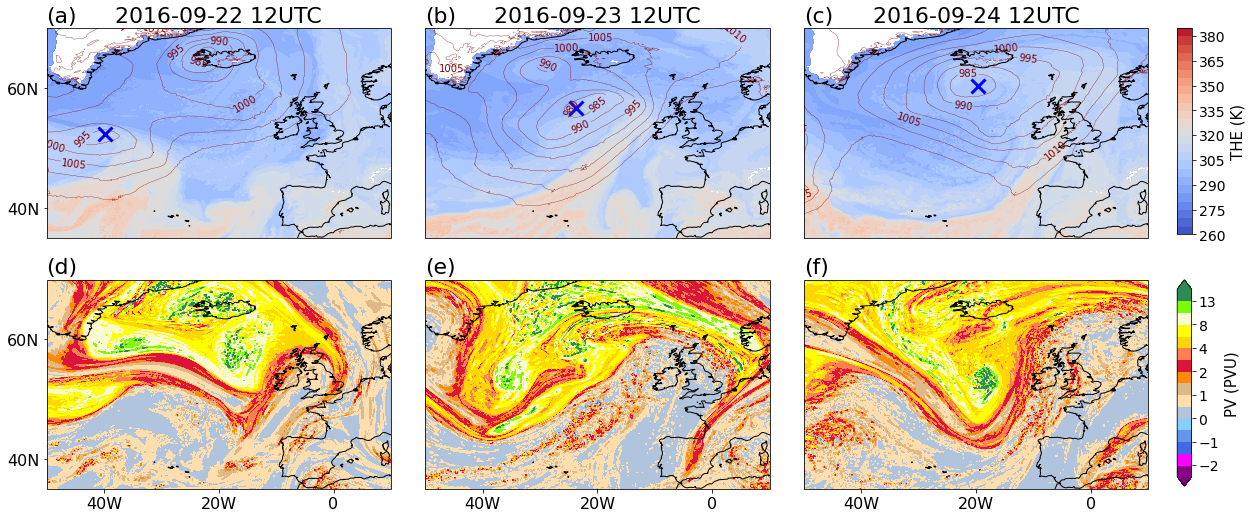

In [3]:
## plot equivalent potential temperature and isentropic potential vorticity at 24h interval

#Loading mean sea level pressure data
ipath='/work/bb1018/b380723/0.025convoff/1m/other/'
file='mslp.nc'
ds=xr.open_dataset(ipath+file)

timesteps = ['2016-09-22T12:00', '2016-09-23T12:00', '2016-09-24T12:00']

#setting map
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(2, 3, figsize=(20,7), subplot_kw=dict(projection=proj))
ax = ax.reshape(-1)
for i in range(ax.shape[0]):
    ax[i].coastlines(rasterized=True)
    ax[i].set_aspect('auto')
    ax[i].tick_params(labelsize=16)
    ax[i].set_extent([-50, 10, 35, 70], ccrs.PlateCarree())
    
    # set xticks and yticks for latitudes and longitudes
    # xaxis: longitudes
    if i in [3, 4, 5]:
        ax[i].set_xticks([-40,-20,0], crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(#zero_direction_label=True,
                                           degree_symbol='',
                                           dateline_direction_label=True)
        ax[i].xaxis.set_major_formatter(lon_formatter)
        del lon_formatter
    # yaxis: latitudes
    if i in [0, 3]:
        ax[i].set_yticks([40,60], crs=ccrs.PlateCarree())
        lat_formatter = LatitudeFormatter(degree_symbol='')
        ax[i].yaxis.set_major_formatter(lat_formatter)
        del lat_formatter
             

fig.canvas.draw()
fig.tight_layout()

#mslp contour
for i in [0,1,2]:
    clevs=np.arange(960,1020,5)
    cf = ax[i].contour(ds.lon, ds.lat,(ds['pres_msl']/100).sel(time=timesteps[i]),clevs,colors='maroon',linewidths=0.3,extend='both')
    plt.clabel(cf, fmt='%d', fontsize=10, inline=1, inline_spacing=5)
    ax[i].set_title(timesteps[i][0:10] + ' ' + timesteps[i][11:13] + 'UTC',loc='center',fontsize=22)
ax[0].set_title('(a)', loc='left', fontsize=22)
ax[1].set_title('(b)', loc='left', fontsize=22)
ax[2].set_title('(c)', loc='left', fontsize=22)

#theta (equivalent potential temperature at 850hPa)
thetae=[]
for i in [22,23,24]:
    with open(ipath+'ap2pl_thetae'+str(i)+'.pkl',"rb") as f:
        thetae.append(pickle.load(f))

#lat-lon information for plotting
data=xr.open_dataset(ipath+'input1.nc')
lon=data.lon
lat=data.lat
del data

#plotting
for i in [0,1,2]:
    clevs=np.arange(260,390,5)
    cf=ax[i].contourf(lon,lat,thetae[i].squeeze(axis=0),clevs, cmap='coolwarm')

#colorbar for theta
cbar_ax = fig.add_axes([0.82, 0.57, 0.01, 0.41]) # left,bottom,width,height
clevs=np.arange(260,390,15)
cb = fig.colorbar(cf, cax=cbar_ax, orientation='vertical', ticks=clevs, extend='')
cb.set_label('THE (K)', fontsize=15, labelpad=5)
cb.ax.tick_params(labelsize=14)
fig.subplots_adjust(right=0.8, wspace=0.1, hspace=0.2)
del cbar_ax, cb, cf, clevs

#cyclone location mark 
data=[]
ds_final_coord=[]
for i in [0,1,2]:
    data.append(ds['pres_msl'].sel(time=timesteps[i]).sel(lat=slice(45, 62), lon=slice(-50,-18)))
    ds_final_coord.append(data[i].where(data[i]==data[i].min(), drop=True))
    ax[i].plot(ds_final_coord[i].lon, ds_final_coord[i].lat, marker='x', markeredgecolor='blue', markersize=14, mew=3)
    
    
#Potential vorticity (PV) on the 320 K isentrope
ipath='/work/bb1018/b380723/0.025convoff/1m/'
ipv=[]
for i in [22,23,24,22,23,24]:
    with open(ipath+'ipv'+str(i)+'.pkl',"rb") as f:
        ipv.append(pickle.load(f))

cmap = mpl.colors.ListedColormap(["purple", "darkmagenta", "magenta", "royalblue", "cornflowerblue", "lightskyblue", "lightsteelblue", "navajowhite", "burlywood", "darkorange", "crimson", "coral", "gold", "yellow", "lightgoldenrodyellow", "lawngreen", "forestgreen", "seagreen"])
norm = mpl.colors.BoundaryNorm([-10,-5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,4,6,8,10.5,13,24], cmap.N)
clevs=[-5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,4,6,8,10.5,13,24]

#lat-lon information for plotting
ds=xr.open_dataset(ipath+'input1.nc')

#plotting
for i in [3,4,5]:
    cf=ax[i].contourf(ds.lon[:-1],ds.lat[:-1],ipv[i]/1e-6,clevs,cmap=cmap,norm=norm,extend='both',transform=ccrs.PlateCarree()) #RdBu_r

ax[3].set_title('(d)', loc='left', fontsize=22)
ax[4].set_title('(e)', loc='left', fontsize=22)
ax[5].set_title('(f)', loc='left', fontsize=22)

# colorbar for PV
cbar_ax = fig.add_axes([0.82, 0.07, 0.01, 0.41]) # left,bottom,width,height
clevs=[-2,-1,0,1,2,4,8,13]
cb = fig.colorbar(cf, cax=cbar_ax, orientation='vertical', ticks=clevs, extend='')
cb.set_label('PV (PVU)', fontsize=15, labelpad=5)
cb.ax.tick_params(labelsize=14)
fig.subplots_adjust(right=0.8, wspace=0.1, hspace=0.2)
del cbar_ax, cb, cf, clevs

plt.show(fig)
plt.close(fig)
del fig, ax, proj
del timesteps